Define variables for computation

In [37]:
# What company to look up, symbol and lower case name
SYMBOL="TSLA" # e.g. "TSLA"
COMPANY="tesla" # e.g. "tesla"
KEYWORD="tesla" # e.g. "tesla"

# What timeframe to lookup as a tuple e.g. (2023, 10, 29)
# if undefined, then it looks up the last month
START_DATE = (2022, 10, 29)
END_DATE = (2023, 10, 29)

# Token for fetching the news
NEWSAPI_TOKEN = '8a15b13e21a844aa8ea71080ce103e13'

Import packages

In [11]:
%load_ext autoreload
%autoreload 2

import importlib
import requests
import yfinance as yf
import pandas as pd
from transformers import pipeline
from collections import defaultdict
from datetime import datetime
import scraper

import matplotlib.pyplot as plt
import matplotlib.dates as mdates


sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Scrape the news from gnews. This takes a while...

(see implementation in scraper.py)

In [45]:
importlib.reload(scraper)

articles = scraper.get_articles(KEYWORD, START_DATE, END_DATE)

articles

Getting articles...
Start querying GNews


10/29/2023 02:49:59 PM - Article `download()` failed with 403 Client Error: Forbidden for url: https://www.investors.com/news/is-tesla-stock-a-buy-or-a-sell-right-now-as-elon-musk-teases-cybertruck/ on URL https://consent.google.com/m?continue=https://news.google.com/rss/articles/CBMiZ2h0dHBzOi8vd3d3LmludmVzdG9ycy5jb20vbmV3cy9pcy10ZXNsYS1zdG9jay1hLWJ1eS1vci1hLXNlbGwtcmlnaHQtbm93LWFzLWVsb24tbXVzay10ZWFzZXMtY3liZXJ0cnVjay_SAQA?oc%3D5&gl=NL&m=0&pc=n&cm=2&hl=en-US&src=1
10/29/2023 02:50:02 PM - Article `download()` failed with 403 Client Error: Forbidden for url: https://www.investors.com/market-trend/stock-market-today/dow-jones-futures-market-rally-holds-key-level-cathie-wood-new-tesla-price-target/ on URL https://consent.google.com/m?continue=https://news.google.com/rss/articles/CBMijAFodHRwczovL3d3dy5pbnZlc3RvcnMuY29tL21hcmtldC10cmVuZC9zdG9jay1tYXJrZXQtdG9kYXkvZG93LWpvbmVzLWZ1dHVyZXMtbWFya2V0LXJhbGx5LWhvbGRzLWtleS1sZXZlbC1jYXRoaWUtd29vZC1uZXctdGVzbGEtcHJpY2UtdGFyZ2V0L9IBAA?oc%3D5&gl=NL

{datetime.datetime(2022, 10, 31, 0, 0): ['In this article TSLA\n\nTWTR Follow your favorite stocks CREATE FREE ACCOUNT\n\nThe Twitter profile page belonging to Elon Musk is seen on an Apple iPhone mobile phone. Nurphoto | Nurphoto | Getty Images\n\nNew Twitter owner Elon Musk has pulled more than 50 of his trusted Tesla employees, mostly software engineers from the Autopilot team, into his Twitter takeover, CNBC has learned. Musk, who is CEO of automaker Tesla and reusable rocket maker SpaceX, completed the $44 billion acquisition of Twitter on Oct. 28 and made his mark there immediately. He fired the company\'s CEO, chief financial officer, policy and legal team leaders right away, and has also dissolved Twitter\'s board of directors. According to internal records viewed by CNBC, employees from Musk\'s other companies are now authorized to work at Twitter, including more than 50 from Tesla, two from the Boring Company (which is building underground tunnels) and one from Neuralink (whi

Now fetch stock data

In [47]:
tsla = yf.Ticker(SYMBOL)

sd = datetime(START_DATE[0], START_DATE[1], START_DATE[2])
ed = datetime(END_DATE[0], END_DATE[1], END_DATE[2])

price_history = tsla.history(start=sd, end=ed)

print(price_history)

                                 Open        High         Low       Close  \
Date                                                                        
2022-10-31 00:00:00-04:00  226.190002  229.850006  221.940002  227.539993   
2022-11-01 00:00:00-04:00  234.050003  237.399994  227.279999  227.820007   
2022-11-02 00:00:00-04:00  226.039993  227.869995  214.820007  214.979996   
2022-11-03 00:00:00-04:00  211.360001  221.199997  210.139999  215.309998   
2022-11-04 00:00:00-04:00  222.600006  223.800003  203.080002  207.470001   
...                               ...         ...         ...         ...   
2023-10-23 00:00:00-04:00  210.000000  216.979996  202.509995  212.080002   
2023-10-24 00:00:00-04:00  216.500000  222.050003  214.110001  216.520004   
2023-10-25 00:00:00-04:00  215.880005  220.100006  212.199997  212.419998   
2023-10-26 00:00:00-04:00  211.320007  214.800003  204.880005  205.759995   
2023-10-27 00:00:00-04:00  210.600006  212.410004  205.770004  207.300003   

Now, we can process this and get the sentiment for all articles

In [48]:
sentiment_per_day = {}

# Go through the articles per day
for date in articles:
  group = articles[date]
  
  score = 0
  
  for article in group:
    # Get the first 512 characters, the model cant handle more.
    sc = sentiment_pipeline(article[:512])[0]
    if sc['label'] == 'POSITIVE':
      score += sc['score']
    else:
      score -= sc['score']
      
  sentiment_per_day[date] = score
      
sentiment_per_day

{datetime.datetime(2022, 10, 31, 0, 0): -0.7485148310661316,
 datetime.datetime(2022, 12, 23, 0, 0): -0.9993751645088196,
 datetime.datetime(2023, 1, 26, 0, 0): 0.655453085899353,
 datetime.datetime(2023, 2, 16, 0, 0): -1.9899314641952515,
 datetime.datetime(2023, 9, 29, 0, 0): 0,
 datetime.datetime(2023, 1, 13, 0, 0): -0.9554990530014038,
 datetime.datetime(2023, 4, 19, 0, 0): -0.9989885687828064,
 datetime.datetime(2023, 1, 25, 0, 0): 0.5943642258644104,
 datetime.datetime(2023, 4, 21, 0, 0): 0,
 datetime.datetime(2022, 11, 10, 0, 0): -0.9994053840637207,
 datetime.datetime(2023, 6, 9, 0, 0): 0.9830638766288757,
 datetime.datetime(2023, 3, 1, 0, 0): 0.01783818006515503,
 datetime.datetime(2023, 1, 3, 0, 0): -1.0099827647209167,
 datetime.datetime(2023, 10, 18, 0, 0): -1.996651291847229,
 datetime.datetime(2023, 7, 20, 0, 0): -2.994504392147064,
 datetime.datetime(2023, 7, 17, 0, 0): -0.9857786893844604,
 datetime.datetime(2023, 4, 3, 0, 0): 0.8935083150863647,
 datetime.datetime(2022

Now link the price history and news-sentiment together

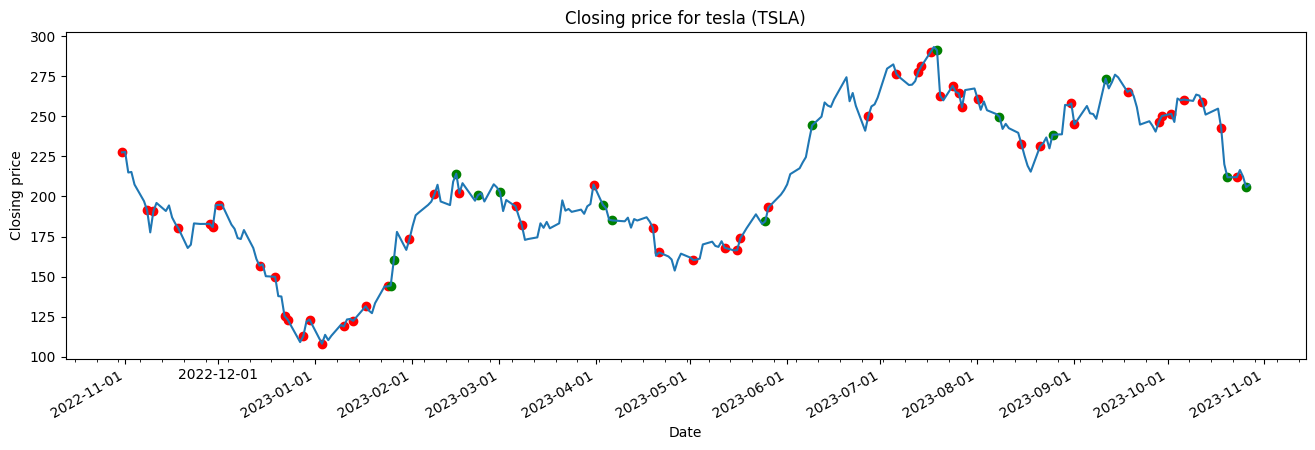

In [59]:
closing = price_history.get('Close')

fig, ax = plt.subplots()

fig.set_figwidth(16)

x = closing.index.to_pydatetime()
y = closing

ax.set_title(f'Closing price for {COMPANY} ({SYMBOL})')

ax.set_xlabel('Date')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

ax.set_ylabel('Closing price')

for date in x:
  price = closing[date]
  
  d = datetime(date.year, date.month, date.day)
  
  sentiment = sentiment_per_day.get(d)
  
  color = 'green' if sentiment and sentiment > 0 else 'red'
  
  # print(f'Datetime: {d} sentiment: {sentiment} color: {color}')
  
  if sentiment != None:
    ax.scatter(date, price, color=color)

ax.plot(x, y)